In [1]:
import os
import time
import dill
from typing import List
from functools import reduce
from calendar import monthrange

In [2]:
import json
import csv
import requests
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import urllib.request as urllib2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from random import sample, randint, shuffle
from sklearn.decomposition import PCA

In [4]:
import nltk
import text_summarizer
from gensim.utils import simple_preprocess
from gensim.summarization.summarizer import summarize
from gensim.models import Word2Vec, LsiModel
from gensim.test.utils import common_dictionary, common_corpus

In [5]:
from time import process_time

In [6]:
t = process_time()
dill.load_session('thesis_env.db')
process_time() - t

60.058654999999995

In [7]:
len(adjectives)

393

In [8]:
len(all_)

1685787

## Gender-neutral adjectives describing people

In [132]:
with open('objects.csv') as csv_file:
    objects = csv_file.read().split("\n")
objects[0] = 'angle'

In [89]:
# url = 'https://www.enchantedlearning.com/wordlist/adjectivesforpeople.shtml'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)

In [8]:
# adjs = [x.contents[0] for x in BeautifulSoup(html).find_all(attrs={"class": "wordlist-item"})]

In [16]:
# with open('adjectives.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(adjs)

In [5]:
with open('adjectives.csv') as csv_file:
    adjectives = csv_file.read().split(",")

In [6]:
adjectives[:5]

['able', 'abnormal', 'above average', 'absent-minded', 'adventurous']

In [7]:
dill.dump_session('thesis_env.db')

In [5]:
# url = 'https://www.britannica.com/topic/list-of-cities-and-towns-in-the-United-States-2023068'
# file = urllib2.urlopen(url)
# html = file.read()
# file.close()
# soup = BeautifulSoup(html)  

In [6]:
# alist = soup.find_all(attrs={"class": "md-crosslink"})

In [7]:
# places = [a.contents[0] for a in alist[3:]]

In [8]:
# len(places)

2010

In [9]:
# with open('cities.csv', mode='w') as f:
#     writer = csv.writer(f, delimiter=',')
#     writer.writerow(places)

In [9]:
with open('cities.csv') as csv_file:
    cities = csv_file.read().split(",")

In [10]:
cities[:5]

['Alabama', 'Alexander City', 'Andalusia', 'Anniston', 'Athens']

# Data Parsing and Processing

In [13]:
class Doc:
    def __init__(self, id: int, gdescriptors: List[str], descriptors: List[str], text: str) -> None:
        self.id = id
        self.gdescriptors = gdescriptors
        self.descriptors = descriptors
        self.text = text

In [14]:
def parse_doc(file: str) -> Doc:
    tree = ET.parse(file)
    root = tree.getroot()
    try:
        fulltext = root.find('body').find('body.content').find("*[@class='full_text']")
        text = reduce(lambda x, y: x + y, [x.text for x in fulltext.findall('p')])
        id = int(root.find('head').find('docdata').find('doc-id').attrib['id-string'])
        classifiers = root.find('head').find('docdata').find('identified-content')
        gclassifiers = classifiers.findall("*[@class='online_producer'][@type='general_descriptor']")
        dclassifiers = classifiers.findall("*[@class='online_producer'][@type='descriptor']")
        gdescriptors = [c.text for c in gclassifiers]
        descriptors = [c.text for c in dclassifiers]
        return Doc(id, gdescriptors, descriptors, text)
    except:
        return None

In [15]:
def get_docs_by_month(year: int, month: int) -> List[Doc]:
    days = monthrange(year, month)[1]
    docs = []
    for day in range(1, days+1):
        for file in os.listdir(f'data/{year}/{month:02}/{day:02}/'):
            doc = parse_doc(f'data/{year}/{month:02}/{day:02}/{file}')
            if doc:
                docs.append(doc)
    return docs

In [13]:
t = time.process_time()
all_ = []
for y in range(1988, 2007):
    print(y)
    for i in range(1,13):
        all_ += get_docs_by_month(y, i)
time.process_time() - t

1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006


973.445533

In [16]:
len(all_)

1685787

In [15]:
dill.dump_session('thesis_env.db')

# Saving files locally and loading

In [18]:
with open('alldocs.json', 'w') as outfile:
    json.dump([x.__dict__ for x in all_], outfile)

In [19]:
def save(i, arr):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'w') as outfile:
        json.dump([x.__dict__ for x in arr], outfile)
    print(time.process_time() - t)

In [20]:
def load(i):
    t = time.process_time()
    with open('alldocs' + str(i) + '.json', 'r') as infile:
        l = json.load(infile)
    print(time.process_time() - t)
    return l

In [11]:
save(0, all_[:600000])

26.122622999999976


In [12]:
l0 = load(0)

89.333306


In [13]:
save(1, all_[600000:1200000])

34.060252999999875


In [14]:
l1 = load(1)

102.26382799999988


In [15]:
save(2, all_[1200000:])

31.626627999999982


In [16]:
l2 = load(2)

19.019525000000158


In [17]:
l = l0 + l1 + l2
len(l)

1685787

# Process by descriptor

In [11]:
t = time.process_time()
alld = {}
for doc in all_:
    doc = Doc(doc.id, doc.gdescriptors, doc.descriptors, doc.text)
    for d in doc.descriptors:
        count, docs = alld.get(d, (0, set()))
        docs.add(doc)
        alld[d] = (count + 1, docs)
time.process_time() - t

39.577875000000006

In [12]:
alldlist = sorted([(d, alld[d][0], alld[d][1]) for d in alld], key=lambda x: x[1], reverse=True)
for x in range(15):
    print(alldlist[x][0:2])

('Terrorism', 12393)
('Books and Literature', 11222)
('Politics and Government', 10589)
('Baseball', 9039)
('United States Politics and Government', 8295)
('Motion Pictures', 7748)
('Music', 7317)
('Weddings and Engagements', 7280)
('Medicine and Health', 6829)
('Travel and Vacations', 6537)
('Deaths (Obituaries)', 6438)
('Television', 6171)
('Football', 6070)
('Computers and the Internet', 5952)
('Basketball', 5746)


In [13]:
def exclude(e, x):
    for d in x.descriptors:
        if d == e:
            continue
        if d in ['Politics and Government', 'Motion Pictures', 'Football', 'Books and Literature', \
                                           'Computers and the Internet', 'Travel and Vacations']:
            return False
    return True

In [14]:
def getlist(topic):
    return list(filter(lambda x: exclude(topic, x), alld[topic][1]))

In [53]:
politics = getlist('Politics and Government')

In [16]:
movies = getlist('Motion Pictures')

In [17]:
fball = getlist('Football')

In [18]:
books = getlist('Books and Literature')

In [54]:
computers = getlist('Computers and the Internet')

In [20]:
travel = getlist('Travel and Vacations')

In [21]:
len(computers), len(politics), len(travel), len(movies), len(fball), len(books)

(5400, 9876, 6162, 7248, 5991, 10227)

In [55]:
politics = sample(politics, 5400)

In [23]:
movies = sample(movies, 5400)

In [24]:
travel = sample(travel, 5400)

In [25]:
fball = sample(fball, 5400)

In [26]:
books = sample(books, 5400)

# Training Word Embeddings

In [27]:
def getw2v(category):
    sentences = []
    for t in category:
        sentences += nltk.sent_tokenize(t.text)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [56]:
t = time.process_time()
mpol = getw2v(politics)
time.process_time() - t

71.66272099999992

In [57]:
t = time.process_time()
mcomp = getw2v(computers)
time.process_time() - t

72.37604099999999

In [30]:
t = time.process_time()
mtrav = getw2v(travel)
time.process_time() - t

90.69895400000001

In [31]:
t = time.process_time()
mmov = getw2v(movies)
time.process_time() - t

74.83457199999998

In [32]:
t = time.process_time()
mbooks = getw2v(books)
time.process_time() - t

76.44018899999998

In [33]:
t = time.process_time()
mfball = getw2v(fball)
time.process_time() - t

100.17447200000004

In [34]:
def top5(word):
    for m in [mpol, mcomp, mtrav, mmov, mbooks, mfball]:
        print([x[0] for x in m.wv.most_similar(positive=[word], topn=5)])

In [58]:
top5('monday')

['tuesday', 'wednesday', 'friday', 'thursday', 'sunday']
['wednesday', 'tuesday', 'thursday', 'friday', 'oct']
['tuesday', 'wednesday', 'thursday', 'friday', 'mondays']
['thursday', 'tuesday', 'wednesday', 'feb', 'sunday']
['wednesday', 'tuesday', 'friday', 'thursday', 'nov']
['thursday', 'friday', 'tuesday', 'wednesday', 'sunday']


In [59]:
top5('house')

['collar', 'assembly', 'chamber', 'congressional', 'congress']
['bus', 'seat', 'bed', 'kitchen', 'desk']
['cottage', 'farmhouse', 'mansion', 'barn', 'guesthouse']
['houses', 'bar', 'garage', 'apartment', 'basement']
['apartment', 'farmhouse', 'town', 'mansion', 'houses']
['car', 'neighborhood', 'apartment', 'restaurant', 'store']


In [60]:
top5('healthy')

['natural', 'meaningful', 'basically', 'safe', 'opportunities']
['meaningful', 'strong', 'proposition', 'eroding', 'slowest']
['serious', 'strong', 'conscious', 'positive', 'subjective']
['sufficient', 'weird', 'healing', 'twinges', 'practical']
['sensible', 'mutually', 'strong', 'aggression', 'longevity']
['confident', 'ready', 'lucky', 'happy', 'fortunate']


In [61]:
top5('success')

['triumph', 'sense', 'weakness', 'view', 'achievement']
['popularity', 'ambitions', 'growth', 'strength', 'strategy']
['strategy', 'confidence', 'product', 'popularity', 'publicity']
['popularity', 'commercial', 'budget', 'blockbuster', 'hit']
['popularity', 'fame', 'criticism', 'subject', 'difficulty']
['experience', 'consistency', 'problems', 'talent', 'improved']


In [62]:
top5('score')

['scoring', 'satire', 'segment', 'prowess', 'correctness']
['digits', 'hips', 'chest', 'incomes', 'toned']
['achievement', 'interpretation', 'personality', 'pedigree', 'animated']
['cinematography', 'composed', 'choreography', 'lyrics', 'soundtrack']
['schedule', 'pounce', 'betting', 'inventory', 'synopsis']
['lead', 'tie', 'attempt', 'turnover', 'catch']


In [63]:
np.mean([len(nltk.word_tokenize(politics[i].text)) for i in range(1000)])

1014.554

In [64]:
np.mean([len(nltk.word_tokenize(computers[i].text)) for i in range(1000)])

1146.449

In [42]:
np.mean([len(nltk.word_tokenize(travel[i].text)) for i in range(1000)])

1453.067

In [43]:
np.mean([len(nltk.word_tokenize(books[i].text)) for i in range(1000)])

1185.256

In [44]:
np.mean([len(nltk.word_tokenize(fball[i].text)) for i in range(1000)])

988.068

In [45]:
np.mean([len(nltk.word_tokenize(movies[i].text)) for i in range(1000)])

1123.286

# Summarization

## TextRank

In [65]:
def getsummaries(category):
    s = []
    fails = []
    for i in range(len(category)):
        try:
            s.append(summarize(category[i].text, word_count=200))
        except:
            fails.append(i)
            print(i)
    return s, fails

In [66]:
t = time.process_time()
summaries_pol, fpol = getsummaries(politics)
time.process_time() - t

1188
1792
3046
3208
5160


81.08962700000006

In [67]:
t = time.process_time()
summaries_comp, fcomp = getsummaries(computers)
time.process_time() - t

2317
3433
4120
4189
4564
4986
5278


86.38642800000002

In [49]:
t = time.process_time()
summaries_trav, ftrav = getsummaries(travel)
time.process_time() - t

109.78976799999998

In [50]:
t = time.process_time()
summaries_mov, fmov = getsummaries(movies)
time.process_time() - t

1111
1233
3358


85.84879699999999

In [51]:
t = time.process_time()
summaries_bks, fbks = getsummaries(books)
time.process_time() - t

767


84.25836300000003

In [52]:
t = time.process_time()
summaries_fball, ffball = getsummaries(fball)
time.process_time() - t

63.64299899999992

## Centroid BOW Summarizer

In [68]:
def getbows(category):
    s = []
    centroid_summarizer = text_summarizer.CentroidBOWSummarizer()
    for i in category:
        try:
            s.append(centroid_summarizer.summarize(i.text, limit=200-30))
        except:
            print(i)
    return s

In [69]:
t = time.process_time()
bow_pol = getbows(politics)
time.process_time() - t

98.04681299999993

In [70]:
len(bow_pol)

5400

In [71]:
t = time.process_time()
bow_comp = getbows(computers)
time.process_time() - t

103.10214300000007

In [72]:
t = time.process_time()
bow_trav = getbows(travel)
time.process_time() - t

127.17146399999979

In [73]:
t = time.process_time()
bow_bks = getbows(books)
time.process_time() - t

108.23139399999991

In [74]:
t = time.process_time()
bow_mov = getbows(movies)
time.process_time() - t

106.02181700000006

In [75]:
t = time.process_time()
bow_fball = getbows(fball)
time.process_time() - t

90.41905699999984

## Centroid Word Embedding Summarizer

In [76]:
embedding_model = text_summarizer.centroid_word_embeddings.load_gensim_embedding_model('glove-wiki-gigaword-50')

In [77]:
centroid_we_summarizer = text_summarizer.CentroidWordEmbeddingsSummarizer(embedding_model, sim_threshold=.99, preprocess_type='nltk')

In [78]:
def getcwe(category):
    s = []
    for i in category:
        try:
            s.append(centroid_we_summarizer.summarize(i.text, limit=200-20))
        except:
            print(i)
    return s

In [79]:
t = time.process_time()
cwe_pol = getcwe(politics)
time.process_time() - t

140.7356719999998

In [80]:
t = time.process_time()
cwe_comp = getcwe(computers)
time.process_time() - t

162.97548199999983

In [81]:
t = time.process_time()
cwe_trav = getcwe(travel)
time.process_time() - t

191.13609600000018

In [82]:
t = time.process_time()
cwe_bks = getcwe(books)
time.process_time() - t

154.46810499999992

In [83]:
t = time.process_time()
cwe_mov = getcwe(movies)
time.process_time() - t

149.37271499999997

In [84]:
t = time.process_time()
cwe_fball = getcwe(fball)
time.process_time() - t

134.564621

In [85]:
np.mean([len(nltk.word_tokenize(getcwe(politics[:100])[i])) for i in range(100)])

221.7

In [86]:
np.mean([len(nltk.word_tokenize(getbows(politics[:100])[i])) for i in range(100)])

227.69

In [87]:
np.mean([len(nltk.word_tokenize(getsummaries(politics[:100])[0][i])) for i in range(100)])

222.99

In [91]:
np.mean([len(nltk.word_tokenize(getctrls(politics[:100])[i])) for i in range(100)])

229.35

## Pseudo-summaries

In [90]:
def getctrls(category):
    ctrls = []
    for a in category:
        sents = nltk.sent_tokenize(a.text)
        rs = [i for i in range(len(sents))]
        shuffle(rs)
        ctrl = []
        count = 0
        for r in rs:
            if count > 200-5:
                break
            count += len(nltk.word_tokenize(sents[r]))
            ctrl.append(sents[r])
        summary = "\n".join([s for s in ctrl])
        ctrls.append(summary)
    return ctrls

In [92]:
t = time.process_time()
ctrls_pol = getctrls(politics)
time.process_time() - t

16.466449999999895

In [93]:
t = time.process_time()
ctrls_comp = getctrls(computers)
time.process_time() - t

15.97608900000023

In [94]:
t = time.process_time()
ctrls_trav = getctrls(travel)
time.process_time() - t

17.73636600000009

In [95]:
t = time.process_time()
ctrls_bks = getctrls(books)
time.process_time() - t

17.248153999999886

In [96]:
t = time.process_time()
ctrls_mov = getctrls(movies)
time.process_time() - t

16.835243999999875

In [97]:
t = time.process_time()
ctrls_fball = getctrls(fball)
time.process_time() - t

15.510351999999784

# Training Word Embeddings on Summaries

In [98]:
def getw2v_s(sums):
    sentences = []
    for t in sums:
        sentences += nltk.sent_tokenize(t)
    docs = [simple_preprocess(s) for s in sentences]
    return Word2Vec(docs)

In [99]:
mpol_s = getw2v_s(summaries_pol)

In [100]:
mcomp_s = getw2v_s(summaries_comp)

In [101]:
mtrav_s = getw2v_s(summaries_trav)

In [102]:
mbks_s = getw2v_s(summaries_bks)

In [103]:
mmov_s = getw2v_s(summaries_mov)

In [104]:
mfball_s = getw2v_s(summaries_fball)

In [105]:
mpol_sb = getw2v_s(bow_pol)
mcomp_sb = getw2v_s(bow_comp)
mtrav_sb = getw2v_s(bow_trav)
mbks_sb = getw2v_s(bow_bks)
mmov_sb = getw2v_s(bow_mov)
mfball_sb = getw2v_s(bow_fball)

In [106]:
mpol_sc = getw2v_s(cwe_pol)
mcomp_sc = getw2v_s(cwe_comp)
mtrav_sc = getw2v_s(cwe_trav)
mbks_sc = getw2v_s(cwe_bks)
mmov_sc = getw2v_s(cwe_mov)
mfball_sc = getw2v_s(cwe_fball)

In [107]:
mpol_c = getw2v_s(ctrls_pol)
mcomp_c = getw2v_s(ctrls_comp)
mtrav_c = getw2v_s(ctrls_trav)
mbks_c = getw2v_s(ctrls_bks)
mmov_c = getw2v_s(ctrls_mov)
mfball_c = getw2v_s(ctrls_fball)

In [108]:
dill.dump_session('thesis_env2.db')

# Bias

Text(0.5, 1.0, 'Explained Variance vs Component Number (Random)')

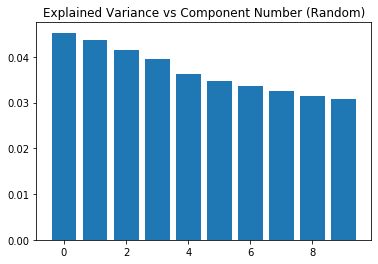

In [165]:
pca_r = PCA(n_components = 10)
pca_r.fit(np.random.rand(70,100))
plt.bar(range(10), pca_r.explained_variance_ratio_)
plt.title("Explained Variance vs Component Number (Random)")

In [136]:
# todo

In [142]:
with open('debiaswe-master/data/equalize_pairs.json') as f:
    pairs = json.loads(f.read())
pairs = list(map(lambda x: [x[0].lower(), x[1].lower()], pairs))

In [183]:
len(pairs)

52

In [121]:
with open('debiaswe-master/data/professions.json') as f:
    profs = json.loads(f.read())
proflist = list(filter(lambda x: x in mpol.wv.vocab, [p[0] for p in profs if abs(p[1]) < 0.6]))

In [139]:
with open('debiaswe-master/data/gender_specific_seed.json') as f:
    gender_specific = json.loads(f.read())

In [143]:
with open('debiaswe-master/data/gender_specific_full.json') as f:
    gender_specific_full = json.loads(f.read())

In [179]:
def getg(m, t, plot):
    matrix = []
    for a, b in pairs:
        if a not in m.wv.vocab or b not in m.wv.vocab:
            continue
        center = (m.wv.get_vector(a) + m.wv.get_vector(b))/2
        matrix.append(m.wv.get_vector(a) - center)
        matrix.append(m.wv.get_vector(b) - center)
    matrix = np.array(matrix)
    p = PCA(n_components = 10)
    p.fit(matrix)
    if plot:
        plt.bar(range(10), p.explained_variance_ratio_)
        plt.title("Explained Variance vs Component Number (" + t + ")")
    return p.components_[0]

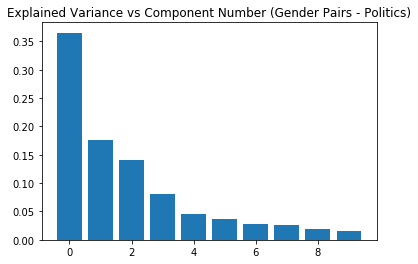

In [182]:
gpol = getg(mpol, "Gender Pairs - Politics", True)

In [181]:
gtrav = getg(mtrav, "Gender, Travel", False)
gcomp = getg(mcomp, "Gender, Computers", False)
gcomp = getg(mcomp, "Gender, Computers", False)

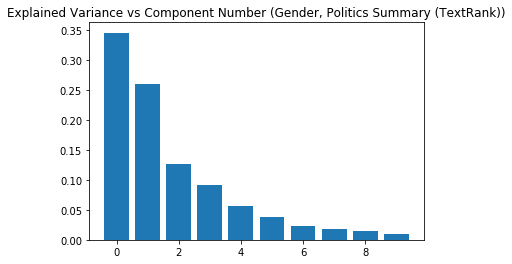

In [166]:
gpol_s = getg(mpol_s, "Gender, Politics Summary (TextRank)")

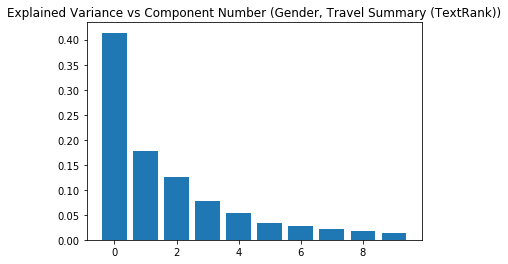

In [174]:
gtrav_s = getg(mtrav_s, "Gender, Travel Summary (TextRank)")

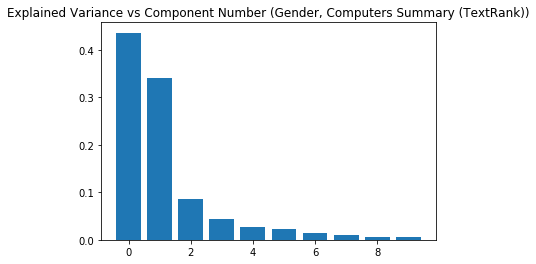

In [167]:
gcomp_s = getg(mcomp_s, "Gender, Computers Summary (TextRank)")

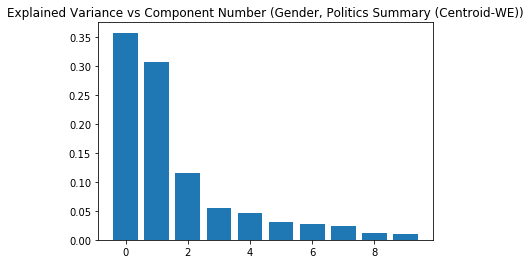

In [175]:
gpol_sc = getg(mpol_sc, "Gender, Politics Summary (Centroid-WE)")

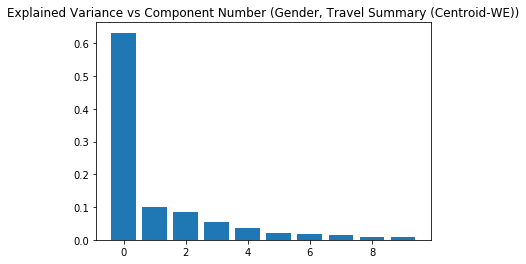

In [178]:
gtrav_sc = getg(mtrav_sc, "Gender, Travel Summary (Centroid-WE)")

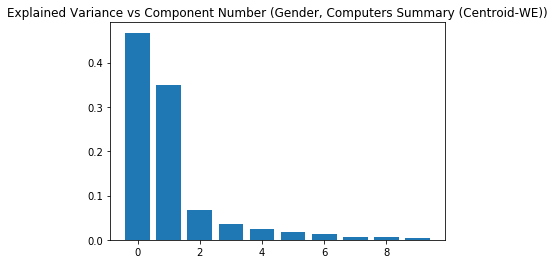

In [177]:
gcomp_sc = getg(mcomp_sc, "Gender, Computers Summary (Centroid-WE)")

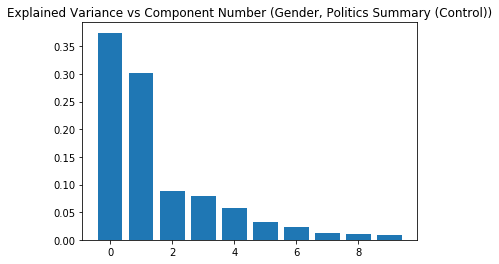

In [172]:
gpol_c = getg(mpol_c, "Gender, Politics Summary (Control)")

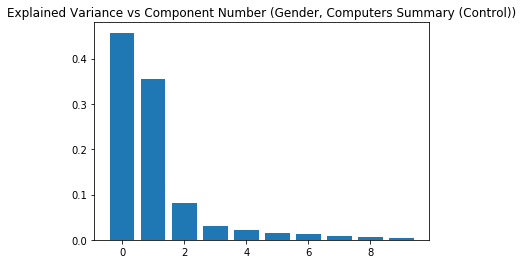

In [170]:
gcomp_c = getg(mcomp_c, "Gender, Computers Summary (Control)")

In [112]:
res = sorted([(x, gproj(gpols_centroid, mpols_centroid, x)) for x in filter(lambda x: x in mpols_centroid.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

she                  -2.2710788249969482 		 he                   2.356893301010132
pretty               -0.508688747882843 		 leadership           1.8383127450942993
guy                  -0.30442196130752563 		 strong               1.207552433013916
mother               -0.3039940297603607 		 politician           0.8111317157745361
dressed              -0.09755730628967285 		 professor            0.705872118473053
smart                -0.09026387333869934 		 architect            0.42393848299980164
blond                -0.08173473924398422 		 scientist            0.15896250307559967
woman                -0.07382756471633911 		 physician            0.1393873393535614
male                 -0.06741078943014145 		 capable              0.11589368432760239
brilliant            -0.05333647131919861 		 philosopher          0.07245338708162308
sewing               -0.015276863239705563 		 man                  0.07010260969400406
handsome             -0.013255850411951542 		 surgeon             

In [123]:
bias(gpols_centroid, mpols_centroid, proflist), bias(gpols, mpols, proflist)

(0.9482668682883479, 0.6022038179460508)

In [137]:
bias(gtravs_centroid, mtravs_centroid, proflist), bias(gtravs, mtravs, proflist)

(0.4050998646040163, 0.13439693361364366)

In [138]:
bias(gcomps_centroid, mcomps_centroid, proflist), bias(gcomps, mcomps, proflist)

(1.8559659211923412, 0.4531655633919334)

In [111]:
def gproj(g, m, w1):
    wvec = m.wv.get_vector(w1)
    p = np.dot(g, wvec)/np.linalg.norm(g)
    return p

In [110]:
wordlist = ['he', 'she', 'doctor', 'nurse', 'man', 'woman', 'male', 'female', 'politician', 'guy', \
            'scientist', 'teacher', 'professor', 'mother', 'pretty', 'handsome', 'strong', 'coward', \
            'timid', 'leadership', 'blond', 'lovely', 'petite', 'surgeon', 'physician', 'shopkeeper', \
            'cooking', 'sewing', 'chuckle', 'sassy', 'lanky', 'competent', 'brilliant', 'capable', 'smart', \
            'intelligent', 'incompetent', 'librarian', 'cosmetics', 'maid', 'clever', 'dressed', 'captain', \
            'nanny', 'philosopher', 'architect', 'financier', 'warrior', 'magician', 'housekeeper', 'homemaker']

In [117]:
res = sorted([(x, gproj(gpol, mpol, x)) for x in filter(lambda x: x in mpol.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

man                  -3.7426586151123047 		 she                  6.507950782775879
he                   -3.2389204502105713 		 woman                3.978196859359741
leadership           -2.6054000854492188 		 female               2.1559529304504395
professor            -2.5416016578674316 		 male                 2.0371978282928467
politician           -2.009556293487549 		 mother               1.9487175941467285
scientist            -1.995765209197998 		 doctor               1.373782992362976
architect            -1.6636126041412354 		 teacher              1.095907211303711
guy                  -1.236844539642334 		 pretty               1.0189235210418701
captain              -0.7500171065330505 		 dressed              0.6161187887191772
strong               -0.729799747467041 		 blond                0.49705949425697327
financier            -0.48084181547164917 		 intelligent          0.4610220789909363
warrior              -0.3460354208946228 		 smart                0.361495286226272

In [123]:
res = sorted([(x, gproj(gtrav, mtrav, x)) for x in filter(lambda x: x in mtrav.wv.vocab, wordlist)], key=lambda x: x[1])
for i in range(20):
    print(f"{res[i][0].ljust(20)} {res[i][1]} \t\t {res[-i-1][0].ljust(20)} {res[-i-1][1]}")

she                  -6.732553958892822 		 he                   5.921176433563232
woman                -2.8284213542938232 		 architect            2.261176347732544
mother               -1.631007432937622 		 man                  1.9642524719238281
lovely               -0.9345683455467224 		 captain              0.5961882472038269
pretty               -0.8737713694572449 		 guy                  0.5897709727287292
teacher              -0.6393272876739502 		 scientist            0.5507559776306152
blond                -0.6306520104408264 		 professor            0.4121052622795105
dressed              -0.5661043524742126 		 politician           0.24364084005355835
cooking              -0.5366024971008301 		 brilliant            0.23765069246292114
female               -0.41221967339515686 		 doctor               0.21805959939956665
nanny                -0.4005126655101776 		 clever               0.209228515625
nurse                -0.35116928815841675 		 capable              0.200958490371

In [114]:
def bias(g, m, wordlist):
    b = 0
    l = list(filter(lambda x: x in m.wv.vocab, wordlist))
    for x in l:
        b += gproj(g, m, x)**2
    return np.sqrt(b/len(l))

In [103]:
def testbias(wordlist):
    print(f"politics: {bias(gpol, mpol, wordlist)}")
    print(f"politics summary: {bias(gpols, mpols, wordlist)}")
    print(f"computers: {bias(gcomp, mcomp, wordlist)}")
    print(f"computers summary: {bias(gcomps, mcomps, wordlist)}")
    print(f"travel: {bias(gtrav, mtrav, wordlist)}")
    print(f"travel summary: {bias(gtravs, mtravs, wordlist)}")

In [126]:
bias(gpol, mpol, proflist), bias(gpols, mpols, proflist)

(1.080344051949677, 0.7235289508241887)

In [130]:
bias(gpol, mpol, gender_specific), bias(gpols, mpols, gender_specific)

(1.4443633579802266, 0.8515114355018824)

In [122]:
testbias(proflist)

politics: 1.080344051949677
politics summary: 0.7235289508241887
computers: 0.5606665330295195
computers summary: 0.39853296151511014
travel: 0.41046785015210885
travel summary: 0.13200765679855686


In [133]:
testbias(gender_specific)

politics: 1.5975402701761838
politics summary: 0.9180423165261025
computers: 1.4735026773405129
computers summary: 1.0926430491214618
travel: 1.364429929965666
travel summary: 0.9591379027237654


In [134]:
testbias(adjectives)

politics: 0.43647351940669277
politics summary: 0.282504577056523
computers: 0.29300878141766545
computers summary: 0.2200760579903955
travel: 0.3566308922040626
travel summary: 0.17490366763962403


In [135]:
testbias(gender_specific_full)

politics: 1.4443633579802266
politics summary: 0.8515114355018824
computers: 1.346425442116525
computers summary: 1.0266586611981627
travel: 1.1662070490016498
travel summary: 0.8557176663216234


## Regression for bias testing

In [140]:
def regress(g1, m1, g2, m2, wordlist):
    x = np.array([gproj(g1, m1, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    y = np.array([gproj(g2, m2, w) for w in wordlist if w in m1.wv.vocab and w in m2.wv.vocab])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, p_value

In [141]:
regress(gpol, mpol, gpols, mpols, proflist)

(0.533629121432331, 1.5349588515623742e-57)

In [142]:
regress(gcomp, mcomp, gcomps, mcomps, proflist)

(-0.47288942755651714, 6.5938456670774195e-21)

In [143]:
regress(gtrav, mtrav, gtravs, mtravs, proflist)

(0.1988740624251196, 4.7826899611645153e-17)

In [148]:
t = time.process_time()
docs = [simple_preprocess(s) for s in controls_pol]
mcpol = Word2Vec(docs)
time.process_time() - t

26.502477999999883

(68, 100)


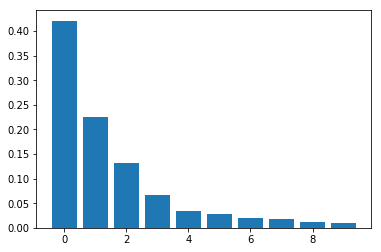

In [149]:
gcpol = getg(mcpol)

In [150]:
bias(gcpol, mcpol, proflist)

0.5980368159429239

In [151]:
words_cpol = []
for s in controls_pol:
    words_cpol += nltk.word_tokenize(s)
len(words_cpol)

2424360

In [152]:
sums_pol = []
for s in summaries_pol:
    sums_pol += nltk.sent_tokenize(s)
len(sums_pol)

72051

In [153]:
words_spol = []
for s in sums_pol:
    words_spol += nltk.word_tokenize(s)
len(words_spol)

3421655

In [154]:
words_pol = []
for p in politics:
    words_pol += nltk.word_tokenize(p.text)
len(words_pol)

10682577

In [166]:
t = time.process_time()
docs = [simple_preprocess(s) for s in swcontrols_pol]
mwcpol = Word2Vec(docs)
time.process_time() - t

105.49074400000018

(66, 100)


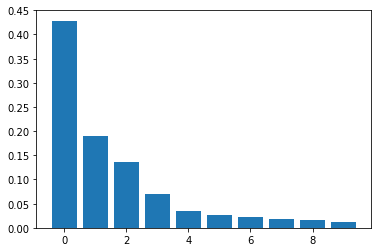

In [159]:
gwcpol = getg(mwcpol)

In [161]:
bias(gwcpol, mwcpol, proflist), bias(gpols, mpols, proflist)

(0.5949498666298728, 0.7235289508241887)

In [162]:
regress(gpols, mpols, gwcpol, mwcpol, proflist)

(-0.76112853809404, 9.301110161945145e-40)

In [163]:
regress(gpol, mpol, gcomp, mcomp, proflist)

(0.28612796610067653, 1.936121103526654e-16)

In [417]:
def testbiaslen(wordlist):
    print(f"politics: {bias(gpol5825, mpol5825, wordlist)}")
    print(f"politics summary (textrank): {bias(gpols5825, mpols5825, wordlist)}")
    print(f"politics summary (centroid BOW): {bias(gpols_centroid5825, mpols_centroid5825, wordlist)}")
    print(f"politics summary (centroid WE): {bias(gpols_centroidwe, mpols_centroidwe, wordlist)}")
    print(f"computers: {bias(gcomp, mcomp, wordlist)}")
    print(f"computers summary: {bias(gcomps, mcomps, wordlist)}")
    print(f"computers summary (centroid BOW): {bias(gcomp_centroid, mcomp_centroid, wordlist)}")
    print(f"computers summary (centroid WE): {bias(gcomps_centroidwe, mcomps_centroidwe, wordlist)}")
    print(f"travel: {bias(gtrav5825, mtrav5825, wordlist)}")
    print(f"travel summary: {bias(gtravs5825, mtravs5825, wordlist)}")
    print(f"travel summary (centroid BOW): {bias(gtravs_centroid5825, mtravs_centroid5825, wordlist)}")
    print(f"travel summary (centroid WE): {bias(gtravs_centroidwe, mtravs_centroidwe, wordlist)}")

In [440]:
testbiaslen(proflist)

politics: 0.7335234985533784
politics summary (textrank): 0.6574114762552342
politics summary (centroid BOW): 1.2824995217263468
politics summary (centroid WE): 1.8274917926411358
computers: 0.7212840233313105
computers summary: 0.450853504622297
computers summary (centroid BOW): 0.52871358749296
computers summary (centroid WE): 1.8170225428357671
travel: 0.41171318892622766
travel summary: 0.12071090081225919
travel summary (centroid BOW): 0.15780635587430647
travel summary (centroid WE): 0.5584299267286956


In [434]:
len(ms_centroid.wv.vocab)

13744